# PhageHostLearn - feature exploration

This notebook explores the constructed language embeddings, both at the RBP and loci levels as well as at the combined level. This notebook follows after having ran the PhageHostLearn_processing steps implemented in the accompanying Jupyter notebook.

Most interestingly, we want to visualize the features related to their K-type and pos/neg interaction. We do this by applying UMAP and PCA to reduce the features and plot them for the RBPs and loci separately (and colored by K-type), and for both of them combined (and colored by K-type, marked by pos/neg).

## 0 - Libraries and directories

In [1]:
import os
import math
import umap
import random
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm
from Bio import SeqIO
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from Bio.Blast.Applications import NcbiblastpCommandline
%matplotlib inline

Init Plugin
Init Graph Optimizer
Init Kernel


In [45]:
valencia_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data' # general directory
data_suffix = 'Valencia' # choose a suffix for the created data files
results_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/feature_exploration/v2.2'
cdpath = '/Users/dimi/cd-hit-v4.8.1-2019-0228'

In [4]:
RBP_embeddings = pd.read_csv(valencia_dir+'/RBP_embeddings.csv')
loci_embeddings = pd.read_csv(valencia_dir+'/loci_embeddings.csv')
interactions = pd.read_csv(valencia_dir+'/phage_host_interactionsValencia.csv', index_col=0)
seros = pd.read_csv(valencia_dir+'/serotypes'+data_suffix+'.csv')
#seros_dict = {key: list(seros['sero']).count(key) for key in unique_seros}

## 1 - Exploring loci embeddings

In [12]:
X_loci = np.asarray(loci_embeddings.iloc[:, 1:])

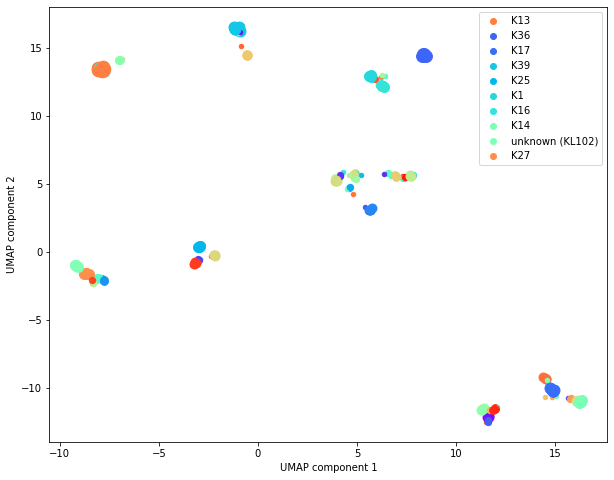

In [46]:
# UMAP of loci embeddings, colored by top10 K-types and sized by frequency of K-type occurrence
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X_loci)
unique_seros = list(set(seros['sero']))
seros_dict = {key: list(seros['sero']).count(key) for key in unique_seros}
top10_seros = [key for key, value in sorted(seros_dict.items(), key=lambda item: item[1], reverse=True)][:10]

fig, ax = plt.subplots(figsize=(10,8))
colors = cm.get_cmap('rainbow')
crange = np.linspace(0.01, 0.99, len(unique_seros))
for i in range(X_umap.shape[0]):
    this_sero = list(seros['sero'])[i]
    col = colors(crange[unique_seros.index(this_sero)])
    ax.scatter(X_umap[i,0], X_umap[i,1], color=col, s=seros_dict[this_sero]*20)
for sero in top10_seros:
    ax.scatter([],[], color=colors(crange[unique_seros.index(sero)]), label=sero)

ax.legend()
ax.set_xlabel('UMAP component 1')
ax.set_ylabel('UMAP component 2')
plt.savefig(results_dir+'/loci_embeddings_UMAP_colorktype.png', dpi=400)

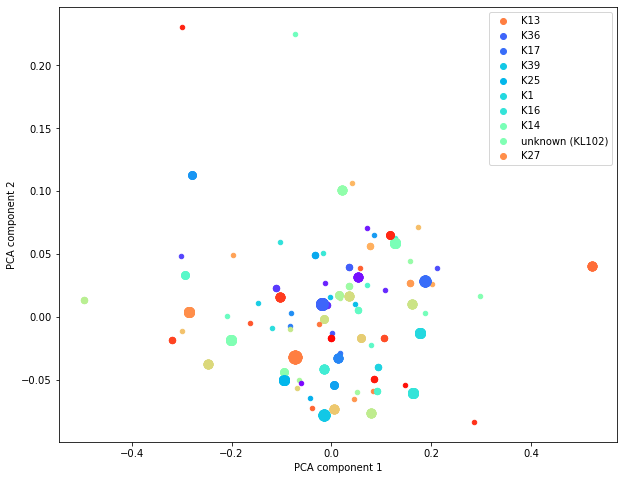

In [47]:
# PCA of loci embeddings, colored by top10 K-types and sized by frequency of K-type occurrence
X_pca = PCA(n_components=2).fit_transform(X_loci)

unique_seros = list(set(seros['sero']))
seros_dict = {key: list(seros['sero']).count(key) for key in unique_seros}
top10_seros = [key for key, value in sorted(seros_dict.items(), key=lambda item: item[1], reverse=True)][:10]

fig, ax = plt.subplots(figsize=(10,8))
colors = cm.get_cmap('rainbow')
crange = np.linspace(0.01, 0.99, len(unique_seros))
for i in range(X_pca.shape[0]):
    this_sero = list(seros['sero'])[i]
    col = colors(crange[unique_seros.index(this_sero)])
    ax.scatter(X_pca[i,0], X_pca[i,1], color=col, s=seros_dict[this_sero]*20)
for sero in top10_seros:
    ax.scatter([],[], color=colors(crange[unique_seros.index(sero)]), label=sero)

ax.legend()
ax.set_xlabel('PCA component 1')
ax.set_ylabel('PCA component 2')
plt.savefig(results_dir+'/loci_embeddings_PCA_colorktype.png', dpi=400)

## 2 - Explore RBP embeddings

The RBP embeddings are more difficult to link to the K-type, as a variety of phages may infect multiple K-types with multiple RBPs! Thus, we can visualize all RBPs but without a color, or we can filter for phages that only infect a single K-type and visualize those.

In [49]:
X_rbps = np.asarray(RBP_embeddings.iloc[:, 2:])

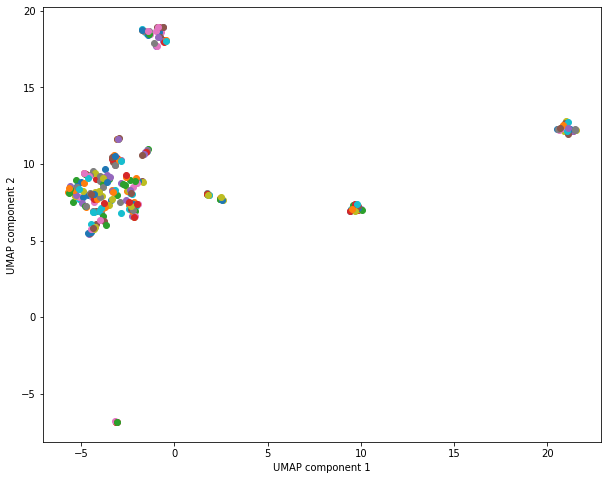

In [51]:
# UMAP of RBP embeddings
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X_rbps)

fig, ax = plt.subplots(figsize=(10,8))
for i in range(X_umap.shape[0]):
    ax.scatter(X_umap[i,0], X_umap[i,1])
#ax.legend()
ax.set_xlabel('UMAP component 1')
ax.set_ylabel('UMAP component 2')
plt.savefig(results_dir+'/RBP_embeddings_UMAP_nocolor.png', dpi=400)

In [73]:
# filter for phages with only one interaction
interactions = interactions.fillna(0)
interactions_mono = interactions.loc[:, (interactions.sum() == 1)]

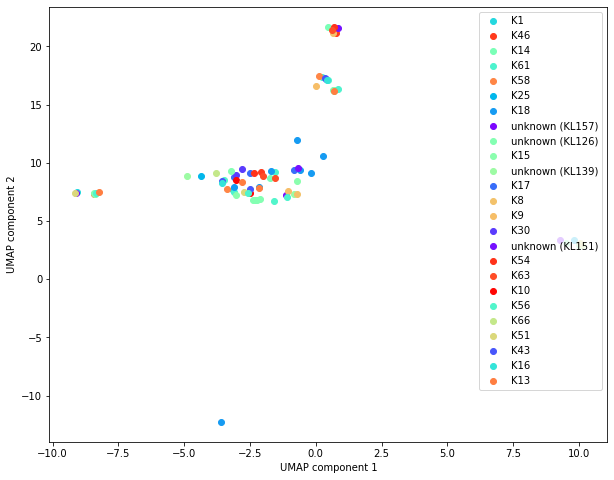

In [100]:
# UMAP of RBP embeddings for phages with only one interaction, colored by K-types
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X_rbps)
unique_seros = list(set(seros['sero']))
colors = cm.get_cmap('rainbow')
crange = np.linspace(0.01, 0.99, len(unique_seros))

fig, ax = plt.subplots(figsize=(10,8))
for i in range(X_umap.shape[0]):
    this_phage = RBP_embeddings['phage_ID'][i]
    if this_phage in list(interactions_mono.columns):
        try:
            this_locus = interactions_mono[this_phage][interactions_mono[this_phage] == 1].index[0] # interaction == 1
            locus_index = list(loci_embeddings['accession']).index(this_locus)
            this_sero = list(seros['sero'])[locus_index]
            col = colors(crange[unique_seros.index(this_sero)])
            ax.scatter(X_umap[i,0], X_umap[i,1], color=col, label=this_sero)
        except:
            pass

handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique))
ax.set_xlabel('UMAP component 1')
ax.set_ylabel('UMAP component 2')
plt.savefig(results_dir+'/mono_interactions_RBPembeddings_UMAP_colorktype.png', dpi=400)

## 3 - Exploring combined embeddings

In [101]:
# construct multi-RBP representations
RBP_embeddings = pd.read_csv(valencia_dir+'/RBP_embeddings.csv')

multi_embeddings = []
names = []
for phage_id in list(set(RBP_embeddings['phage_ID'])):
    rbp_embeddings = RBP_embeddings.iloc[:,2:][RBP_embeddings['phage_ID'] == phage_id]
    multi_embedding = np.mean(np.asarray(rbp_embeddings), axis=0)
    names.append(phage_id)
    multi_embeddings.append(multi_embedding)
multiRBP_embeddings = pd.concat([pd.DataFrame({'phage_ID': names}), pd.DataFrame(multi_embeddings)], axis=1)

In [103]:
# construct dataframe for training
loci_embeddings = pd.read_csv(valencia_dir+'/loci_embeddings.csv')
interactions = pd.read_csv(valencia_dir+'/phage_host_interactionsValencia.csv', index_col=0)
features = []
labels = []
seros_list = []
for i, accession in enumerate(loci_embeddings['accession']):
    for j, phage_id in enumerate(multiRBP_embeddings['phage_ID']):
        interaction = interactions.loc[accession][phage_id]
        if math.isnan(interaction) == False: # if the interaction is known
            features.append(pd.concat([loci_embeddings.iloc[i, 1:], multiRBP_embeddings.iloc[j, 1:]]))
            labels.append(int(interaction))
            seros_list.append(list(seros['sero'])[i])
features = np.asarray(features)
print("Dimensions match?", features.shape[1] == (loci_embeddings.shape[1]+multiRBP_embeddings.shape[1]-2))

Dimensions match? True


In [ ]:
# UMAP of combined embeddings, colored by top10 K-types and sized by frequency of K-type occurrence
reducer = umap.UMAP()
X_umap = reducer.fit_transform(features)
unique_seros = list(set(seros_list))
seros_dict = {key: seros_list.count(key) for key in unique_seros}
top15_seros = [key for key, value in sorted(seros_dict.items(), key=lambda item: item[1], reverse=True)][:15]

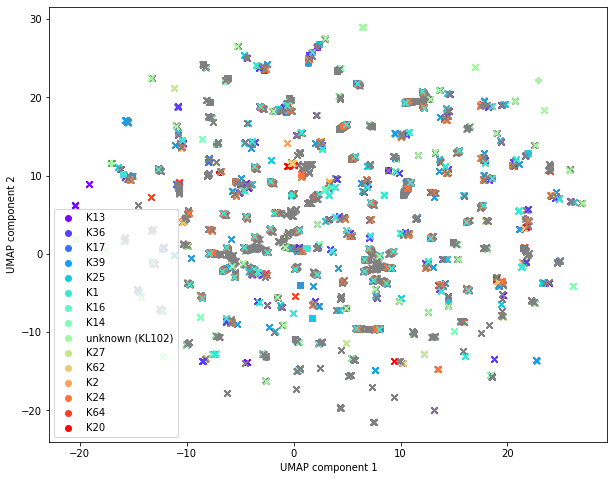

In [112]:
fig, ax = plt.subplots(figsize=(10,8))
colors = cm.get_cmap('rainbow')
crange = np.linspace(0.01, 0.99, 15)
for i in range(X_umap.shape[0]):
    this_sero = seros_list[i]
    if this_sero in top15_seros:
        col = colors(crange[top15_seros.index(this_sero)])
    else:
        col = 'grey'
    if labels[i] == 1:
        mark = 'P'
    else:
        mark = 'x'
    ax.scatter(X_umap[i,0], X_umap[i,1], color=col, marker=mark)
for sero in top15_seros:
    ax.scatter([],[], color=colors(crange[top15_seros.index(sero)]), label=sero)

ax.legend()
ax.set_xlabel('UMAP component 1')
ax.set_ylabel('UMAP component 2')
plt.savefig(results_dir+'/combined_embeddings_UMAP_colorktype.png', dpi=400)

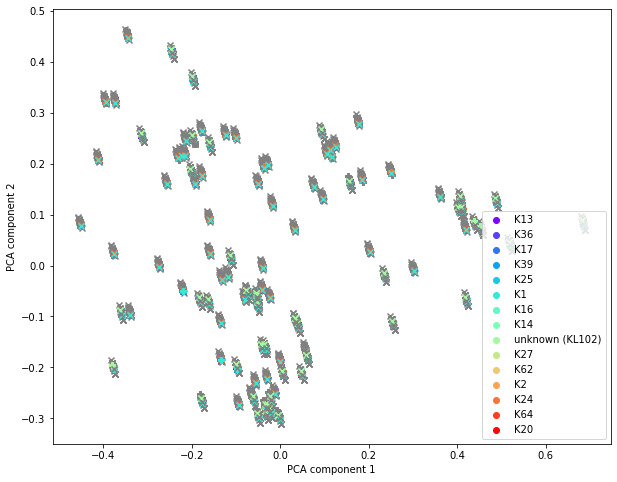

In [113]:
X_pca = PCA(n_components=2).fit_transform(features)
fig, ax = plt.subplots(figsize=(10,8))
colors = cm.get_cmap('rainbow')
crange = np.linspace(0.01, 0.99, 15)
for i in range(X_pca.shape[0]):
    this_sero = seros_list[i]
    if this_sero in top15_seros:
        col = colors(crange[top15_seros.index(this_sero)])
    else:
        col = 'grey'
    if labels[i] == 1:
        mark = 'P'
    else:
        mark = 'x'
    ax.scatter(X_pca[i,0], X_pca[i,1], color=col, marker=mark)
for sero in top15_seros:
    ax.scatter([],[], color=colors(crange[top15_seros.index(sero)]), label=sero)

ax.legend()
ax.set_xlabel('PCA component 1')
ax.set_ylabel('PCA component 2')
plt.savefig(results_dir+'/combined_embeddings_PCA_colorktype.png', dpi=400)

On the last PCA here, we clearly see a patern we've already encountered in earlier explorations: that multiple similar datapoints (one phage with multiple loci) get plotted nearly on the same spot. But in a sense, we probably shouldn't have expected these extreme reductions of features to yield good splits anyway.